In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import cv2
import numpy as np
import pandas as pd
from time import time
import pydicom
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from skimage.color import gray2rgb
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, GlobalMaxPooling2D, Activation, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3


In [2]:
# Path
base_path = "siim-covid19-detection/"
base_train_path = "siim-covid19-detection/train/"
base_test_path = "siim-covid19-detection/test/"
png_path = "siim-covid19-resized-to-512px-png/"
output_path = "output/"

# Final image size for model input
img_size = 299

# # number of images in each of the two classes to get into the train set. Keep it real small for this demo.
# num_images = 1000

# Number of epochs
epochs = 10

# number of batches
batch_size = 512

In [3]:
# Load the data
studies_df = pd.read_csv(os.path.join(base_path,"train_study_level.csv"))
images_df = pd.read_csv(os.path.join(base_path,"train_image_level.csv"))

# Loop through the dfs and remove the "_study" and "_image" from the ids so we can use them as keys to join on later
# studies_df['id'] = studies_df['id'].map(lambda x: x.rstrip('_study'))
# images_df['id'] = images_df['id'].map(lambda x: x.rstrip('_image'))
studies_df['id'] = studies_df['id'].map(lambda x: x[:-6])
images_df['id'] = images_df['id'].map(lambda x: x[:-6])

# # Merge the study and image df's on StudyInstanceUID
# data_df = pd.merge(images_df, studies_df, how='inner', left_on='StudyInstanceUID', right_on='id')
# data_df.drop(['id_y'], axis=1, inplace=True)

# # Split the studies dataframe into negative and positive dataframes
# positive_images_df = data_df[data_df['Negative for Pneumonia'] == 0]
# negative_images_df = data_df[data_df['Negative for Pneumonia'] == 1]

In [4]:
# This function finds the first image in a StudyInstanceUID directory and returns its ID
# data_group = 0 for train data, 1 for test data
def get_image_id_by_study_id(study_id, data_group):
    tmp_df = images_df[images_df['StudyInstanceUID'] == study_id]
    if (tmp_df.shape[0] == 0):
        print("Study id", study_id, "not found!")
        return "none"
    else:
        return tmp_df["id"].head(1).item()

In [5]:
# This function finds the first image in a StudyInstanceUID directory and returns its path
def get_image_by_study_id(study_id, data_group):
    if (data_group == 0):
        group_name = "train/"
    elif (data_group == 1):
        group_name = "test/"
    else:
        print("error: wrong paramter for data_group")
        return
    img_id = get_image_id_by_study_id(study_id, data_group)
    return png_path + group_name + str(img_id) + ".png"

In [6]:
study_id = studies_df["id"][0]
tmp_df = images_df[images_df['StudyInstanceUID'] == study_id]
tmp_df["id"].head(1).item()

'65761e66de9f'

siim-covid19-resized-to-512px-png/train/136af218f8df.png
image array shape: (512, 512)
Pixel range: 0.0 - 1.0


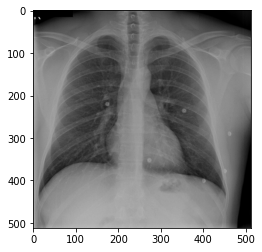

In [7]:
# Take a look at a random image
img_path = get_image_by_study_id("00c74279c5b7", 0)
print(img_path)

img = plt.imread(img_path)
plt.imshow(img, cmap="gray")

img_array = np.array(img)
print("image array shape:", img_array.shape)
print("Pixel range: " + str(np.amin(img_array)) + " - " + str(np.amax(img_array)))

In [8]:
def collect_png_data(start, end, img_size_):
    # Collect image data and label
    start_time = time()

    X_train_data = []
    y_train_data = []

    # Iterate through the rows of the DF
    count = 0
    for index, row in studies_df.iterrows():
        img_file = get_image_by_study_id(row['id'], 0)
        # Only collect from "start" to "end-1"
        if (start <= count and count < end):
            img = plt.imread(img_file)
            img = resize(img, (img_size_, img_size_))
            X_train_data.append(np.array(img))

            img_label = np.array([row['Negative for Pneumonia'],
                                    row['Typical Appearance'],
                                    row['Indeterminate Appearance'],
                                    row['Atypical Appearance']])
            # Check label
            if (np.sum(img_label) != 1 or np.amax(img_label) != 1 or np.amin(img_label) != 0):
                print("Image ", img_file, "does not have a vald label.")
                continue
            y_train_data.append(img_label)
        count += 1
        if (count >= end):
            break
    
    data_num = len(X_train_data)
    
    print("Done getting " + str(data_num) + " images")
    print("Time elapsed:", time() - start_time)
    
    return X_train_data, y_train_data, data_num

In [9]:
X_train_data, y_train_data, data_num = collect_png_data(0, 10, img_size)

print("Data range: " + str(np.amin(X_train_data[0])) + " - " + str(np.amax(X_train_data[0])))
print("X_train_data length:", len(X_train_data))
print("X_train_data[0] shape:", X_train_data[0].shape)

Done getting 10 images
Time elapsed: 0.17093896865844727
Data range: 0.0 - 0.98039216
X_train_data length: 10
X_train_data[0] shape: (512, 512)


In [10]:
# Collect PNG data, one for each study
start_time = time()
X_train_data, y_train_data, data_num = collect_png_data(0, 10000, img_size)
# Rescaling image data to [-1, 1] for tensorflow input
X_train_data = np.array(X_train_data) * 2.0 - 1.0
# X_train_data = np.load(output_path + "X_train_data.npy")
# y_train_data = np.load(output_path + "y_train_data.npy")
print("Time elapsed:", time() - start_time)

Time elapsed: 47.45746421813965


In [11]:
print("Data range: " + str(np.amin(X_train_data[0])) + " - " + str(np.amax(X_train_data[0])))
print("X_train_data length:", len(X_train_data))
print("X_train_data[0] shape:", X_train_data[0].shape)

Data range: -1.0 - 0.9607843
X_train_data length: 6054
X_train_data[0] shape: (512, 512)


In [12]:
# Save X_train_data and y_train_data for further usage
np.save(output_path + "X_train_data.npy", X_train_data)
np.save(output_path + "y_train_data.npy", y_train_data)

In [13]:
# Split the train/test data
X_train, X_test, y_train, y_test = train_test_split(X_train_data, y_train_data, test_size = 0.3, random_state = 114514, shuffle=True)
print("X_train len: " + str(len(X_train)))
print("y_train len: " + str(len(y_train)))
print("X_test len: " + str(len(X_test)))
print("y_test len: " + str(len(y_test)))

# Convert the lists to arrays
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

# Free Memory
del X_train_data
del y_train_data

# Reshape the images to 3 channels
X_train = gray2rgb(X_train)
X_test = gray2rgb(X_test)


X_train len: 4237
y_train len: 4237
X_test len: 1817
y_test len: 1817


In [14]:
# Use InceptionV3 to extract features
start_time = time()

pre_trained_model = InceptionV3(input_shape = (img_size, img_size, 3), include_top = False, weights = "imagenet")

# Freeze the lower layers
for layer in pre_trained_model.layers:
     layer.trainable = False
        
last_layer = pre_trained_model.get_layer('mixed8')
last_output = last_layer.output

# Add our layer
layer = Flatten()(last_output)
layer = Dense(1024, activation='relu')(layer)
layer = Dropout(0.2)(layer)
layer = Dense(4, activation='sigmoid')(layer)

# layer = Conv2D(1024, (5, 5), activation='relu')(last_output)
# layer = Dropout(0.5)(layer)
# layer = BatchNormalization()(layer)
# layer = Conv2D(1024, (5, 5), activation='relu')(layer)
# layer = Dropout(0.5)(layer)
# layer = BatchNormalization()(layer)
# layer = Conv2D(1024, (5, 5), activation='relu')(layer)
# layer = Dropout(0.5)(layer)
# layer = BatchNormalization()(layer)
# layer = Flatten()(layer)
# layer = Dense(1024, activation='relu')(layer)
# layer = Dropout(0.5)(layer)
# layer = Dense(1, activation='sigmoid')(layer)

model = Model(pre_trained_model.input, layer)
model.compile(optimizer = RMSprop(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['acc'])
# model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])

print("Time elapsed:", time() - start_time)



Time elapsed: 2.9257750511169434


In [15]:
# # check pre_trained_model outputs
# for layer in pre_trained_model.layers:
#     print(layer.output_shape, layer.name)

In [16]:
# # check model outputs
# for layer in model.layers:
#     print(layer.output_shape, layer.name)

In [17]:
# # Tensorflow requires input to be normalized into [-1, 1]
# X_train_data = np.array(X_train_data)
# X_train_data = gray2rgb(X_train_data) * 2.0 - 1.0

In [18]:
# # Produce my features
# start_time = time()

# # X_feature_data = []
# # for i in range(X_train_data.shape[0]):
# #     x_feature = model.predict(X_train_data[i])
# #     X_feature_data.append(x_feature)

# X_feature_data = []
# y_feature_data = []
# for i in range(100):
#     X_train_data, y_train_data, data_num = collect_png_data(100*i, 100*(i+1))
#     if (data_num == 0):
#         break
#     X_feature_data += list(np.float16(model.predict(X_train_data)))
#     y_feature_data += y_train_data
#     print("Episode:", i, ", time elapsed:", time() - start_time)

# print("Time elapsed:", time() - start_time)

In [19]:
# # Save X_feature_data and y_feature_data for further usage
# start_time = time()
# np.save("/kaggle/working/X_feature_data.npy", X_feature_data)
# np.save("/kaggle/working/y_feature_data.npy", y_feature_data)
# print("Saved.")
# print("Time elapsed:", time() - start_time)

In [20]:
# # In case of out of memory
# config = tf.compat.v1.ConfigProto(allow_soft_placement=True)
# config.gpu_options.allow_growth = True
# sess = tf.compat.v1.Session(config = config)
# gpu_options = tf.GPUOptions(allow_growth=True)
# sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [21]:
start_time = time()

# Fit the data
history=model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,verbose=1,validation_data=(X_test,y_test))

print("Time elapsed:", time() - start_time)

Epoch 1/10


In [ ]:
# # Save the model
# model.save(output_path + "model_inceptionV3_0.hd5")


Error: Session cannot generate requests